The aim of this project is to exlpore the AirBnB data and answer the questions below - 

       Which hosts are the busiest and why?
       What areas have more traffic than others and why is that the case?
       Are there any relationships between prices and number of reviews for a given listing?
       
The dataset can be found at this <a href=https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data>Link</a>
<br>
Descirbing a few columns :-

       name - name of the listing
       calculated_host_listings_count - amount of listings per host
       availability_365 - Number of days when listing is available for booking
       neighbourhood_group - Location
       last_review - date of last review
       reviews_per_month - number of reviews per month on average

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Importing the dataset

In [2]:
df = pd.read_csv('/home/hp/Downloads/AB_NYC_2019.csv')
df.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [8]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [92]:
df[df.last_review.isna() & df.reviews_per_month.isna()].number_of_reviews.value_counts()

0    10052
Name: number_of_reviews, dtype: int64

Looking at the null values in the `last_review` and `reviews_per_month` columns, we can see, it is Null whenever `number_of_reviews` is 0. Hence we can fill these Null values with a 0

In [3]:
df[['last_review','reviews_per_month']] = df[['last_review','reviews_per_month']].fillna(0)

For the Null values in the `host_name` column, there isnt any other data from which we can impute these values and hence we simply ignore these rows. Similarly Null values in the `name` column can be ignored as the column is irrelevant to our exploration.

In [21]:
df.host_name.value_counts(dropna=False)

Michael         417
David           403
Sonder (NYC)    327
John            294
Alex            279
               ... 
DyAnna            1
Keyur             1
Ossama            1
Jonatan           1
Kwankaew          1
Name: host_name, Length: 11453, dtype: int64

Multiple hosts have multiple listings in the data

Now to explore the first question - Which hosts are the busiest and why?<br>
We are first going to have to define what we mean by busiest. Looking at the data we can see a few columns that can help us - `reviews_per_month`, `availability_365` and `minimum_nights`.

The `availability_365` represents the number of days in a year, the location is open for bookings. All rows having 0 for this means, this place is temporarily closed down. Hence it makes sense to remove these from our discussion.
This means the population for the analysis is the set of all listings on AirBnB website. The sample chosen for the analysis is a set of those listings who are currently accepting bookings.

In [4]:
df = df[df.availability_365 > 0]

The `minimum_nights` column has many outliers with values exceeding `availability_365` or even out of bounds of 365, thus we will remove these rows from our dataset as well (there is no way we can impute them)

In [5]:
df = df[df.minimum_nights <= df.availability_365]

Now we are going to create a metric via which we estimate the hosts to be busy. We have taken the 3 columns into consideration as mentioned above, after cleaning them. <br>
Firstly we will calculate the Months the listing is available for booking :-

   <h6>available months =  <B><sup>available days</sup> / <sub>(365/12) </sub></B></h6> 
    
Next we will try to find the maximum possible bookings a listing can have through the available days, here the assumption is that, every customer stays exactly equal to minimum nights required by the listing :-

   <h6>total possible bookings = <B><sup>available days</sup> / <sub>minimum nights</sub></B></h6>

The next step is to estimate the number of bookings that occured in the year. For this we assume that the number of reviews recieved per month means that many customers on average booked/stayed in this listing. Hence we will estimate bookings as :-

   <h6>estimated bookings = <b>reviews per month x available months</b></h6>
   
Finally the percentage of occupancy throughout the year is gives as :-

   <h6>occupancy % = <b><sup>estimated bookings</sup> / <sub>total possible bookings</sub> x 100</b></h6>

Another assumption we make here is that, a Host with 1 customer as the listing's total possible booking records a 100% when the estimated bookings is also 1, This scenario is also assumed to be busy as the Hosts asset does not go unoccupied.

In [6]:
avg_month_length = 365/12
df['availability_months'] = df.availability_365 / avg_month_length

df['max_possible_bookings'] = df.availability_365 / df.minimum_nights
df['booking_estimate'] = df.reviews_per_month * df.availability_months

As mentioned above, after all the calculations we still have outliers where the estimated booking is more than the total possible bookings. This is because of the fact that the column `reviews_per_month` is an average values and can show a very optimistic side for a few rows. Hence we will disregard these rows.

In [7]:
df = df[df.booking_estimate <= df.max_possible_bookings]

Calculating the occupancy % as explained above.

In [8]:
df['occupancy_percentage'] = (df.booking_estimate / df.max_possible_bookings) * 100
df.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,availability_months,max_possible_bookings,booking_estimate,occupancy_percentage
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,12.000000,365.000000,2.520000,0.690411
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,11.671233,355.000000,4.435068,1.249315
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0,0.00,1,365,12.000000,121.666667,0.000000,0.000000
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,6.378082,194.000000,29.594301,15.254795
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,4.241096,43.000000,2.502247,5.819178


The `host_name` column contains names that repeat, the `calculated_host_listings_count` gives us a fair idea for this, hence we will use `host_id` as primary for the `groupby` function followed by `host_name` as we want the names of the hosts. We will use `mean` as the aggregate function for the `occupancy_percentage` and `price` column to get a fair idea about the general trend for each host, whereas for the `neighbourhood_group` and `neighbourhood` columns we will use the mode indicating the location where majority of host's properties reside.

In [9]:
grouped = df[[
    'host_id',
    'host_name',
    'occupancy_percentage',
    'price'
    ,'neighbourhood_group',
    'neighbourhood'
]].groupby(['host_id','host_name'])

df_occupancy = grouped.agg({
    'occupancy_percentage':'mean',
    'price':'mean',
    'neighbourhood_group':pd.Series.mode,
    'neighbourhood':pd.Series.mode
}).reset_index()

Displaying the Top 50 busiest Hosts.

In [10]:
Top_50 = df_occupancy.sort_values('occupancy_percentage',ascending=False).head(50)
Top_50

,host_id,host_name,occupancy_percentage,price,neighbourhood_group,neighbourhood
8697,22223682,Zoey,98.630137,150.0,Manhattan,Upper West Side
13342,73986440,Daniel,98.630137,150.0,Manhattan,Financial District
19868,257674218,Jordi,98.630137,349.0,Manhattan,Chelsea
18227,214187963,Amanda,98.630137,217.5,Manhattan,West Village
2030,1646818,Sara,98.630137,120.0,Brooklyn,Williamsburg
12199,53462017,Harry,98.630137,135.0,Manhattan,Upper West Side
9970,30933227,Dipti,98.630137,130.0,Manhattan,Kips Bay
7299,15010630,Poma,98.630137,216.0,Manhattan,Chelsea
14900,110448579,Moncef,98.630137,78.0,Brooklyn,Flatbush
4282,5153401,Danielle,98.630137,160.0,Brooklyn,Fort Greene


Analysing our `Top_50` hosts, let us make frequency distribution table for the `neighbourhood_group`, we will not choose `neighbourhood` here as it is granular information and even for the Top 50 hosts there are too many unique values. This will make it harder for us to analyse.

In [50]:
Top_50.neighbourhood_group.value_counts()

Manhattan        26
Brooklyn         20
Queens            3
Staten Island     1
Name: neighbourhood_group, dtype: int64

We can right off the bat notice that majority of these hosts have atleast one of their properties in either Manhattan or Brooklyn. These differences are very clear. 

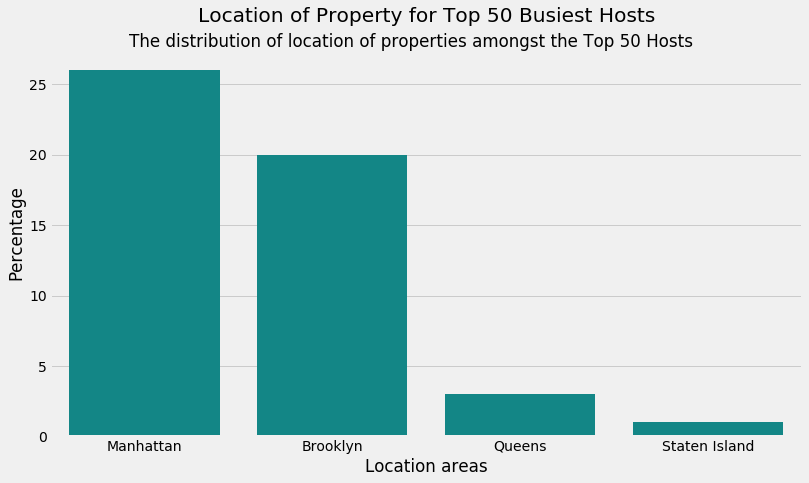

In [18]:
# percentages = Top_50.neighbourhood_group.value_counts(normalize=True) * 100

plt.figure(figsize=(12,7))
plt.style.use('fivethirtyeight')
sns.countplot(Top_50.neighbourhood_group,color='#009999',)
plt.title('Location of Property for Top 50 Busiest Hosts',y=1)
plt.suptitle('The distribution of location of properties amongst the Top 50 Hosts ',y=0.87)
plt.ylim(0,29)
plt.xlabel('Location areas')
plt.ylabel('Percentage')
plt.show()

As we can see, the Top 50 Hosts have their assets mainly in `Manhatten` and `Brooklyn`

For the next question - What areas have more traffic than others and why is that the case?, the sample under consideration is `df_occupancy` as we have the busiest hosts in it. <br>

We have two levels in terms of location for this problem. One is the more general `neighbourhood_group` and the other on a granular level `neighbourhood`. Starting on level 1, let us first analyse the general category of locations the properties reside in.

In [19]:
df_occupancy.neighbourhood_group.value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


Manhattan                  8722
Brooklyn                   8591
Queens                     2737
Bronx                       627
Staten Island               218
[Brooklyn, Queens]            1
[Brooklyn, Queens]            1
[Manhattan, Queens]           1
[Bronx, Manhattan]            1
[Brooklyn, Manhattan]         1
[Brooklyn, Manhattan]         1
[Brooklyn, Manhattan]         1
[Brooklyn, Manhattan]         1
[Brooklyn, Manhattan]         1
[Bronx, Manhattan]            1
[Brooklyn, Queens]            1
[Manhattan, Queens]           1
[Brooklyn, Queens]            1
[Brooklyn, Queens]            1
[Bronx, Manhattan]            1
[Brooklyn, Queens]            1
[Manhattan, Queens]           1
[Brooklyn, Queens]            1
[Brooklyn, Queens]            1
[Manhattan, Queens]           1
[Brooklyn, Queens]            1
[Brooklyn, Manhattan]         1
[Queens, Staten Island]       1
[Brooklyn, Queens]            1
[Brooklyn, Manhattan]         1
[Bronx, Manhattan]            1
[Brookly

Due to the internal working of the mode function, for those hosts having equal number of properties in multiple locations, the mode returned a list. Before we proceed we will have to clean this. Since the lists are too few, we can take either values from the list.

In [20]:
def clean_loc(data):
    if len(data) < 4:
        return data[1]
    else: 
        return data
    
df_occupancy.neighbourhood_group = df_occupancy.neighbourhood_group.apply(clean_loc)

Now grouping the sample by `neighbourhood_group` and taking a mean of `occupancy_percentage` to get a distribution of the occupancy across the neighbourhood groups.

In [21]:
grouped = df_occupancy[['occupancy_percentage','neighbourhood_group']].groupby('neighbourhood_group')
df_location_group = grouped.mean().reset_index()
df_location_group

,neighbourhood_group,occupancy_percentage
0,Bronx,11.183107
1,Brooklyn,12.842437
2,Manhattan,13.494810
3,Queens,12.469328
4,Staten Island,12.659044


The differences between the locations is very little, a visualization can help us better understand the differences.

Text(0.5, 1.0, 'Percentage of occupancy vs Location')

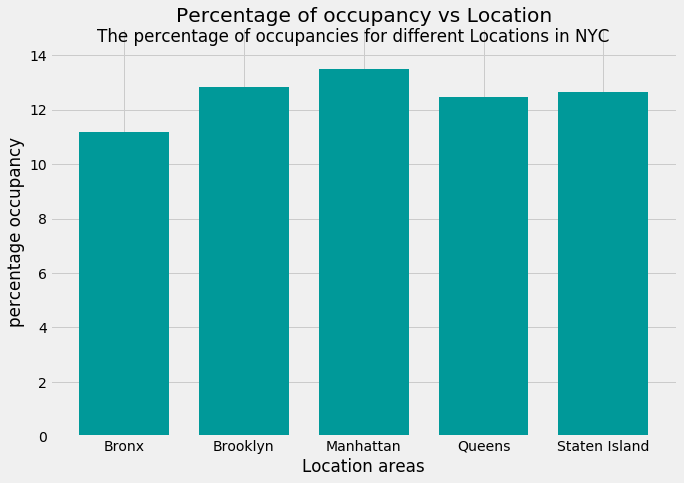

In [23]:
plt.figure(figsize=(10,7))
plt.style.use('fivethirtyeight')
plt.bar(df_location_group.neighbourhood_group,df_location_group.occupancy_percentage,color='#009999',width=0.75)
plt.ylim(0,15)
plt.xlabel('Location areas')
plt.ylabel('percentage occupancy')
plt.suptitle('The percentage of occupancies for different Locations in NYC',y=0.88)
plt.title('Percentage of occupancy vs Location')

The plot above shows that among the location areas, the areas having more traffic than others are - `Manhattan`, `Brooklyn` and `Staten Island` in close third. <br>
Combining the results of this and the previous plot, we can claim that, Hosts having properties in the areas, `Manhatten`, `Brooklyn` and `Staten Island` are busier than the rest in general.

For these 3 locations, we can now analyse granular information to find more specific locations in these 3 areas that recieve more traffic than the rest of the locations.

In [24]:
df_occupancy.neighbourhood.value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


Williamsburg                      1612
Bedford-Stuyvesant                1597
Harlem                            1203
Bushwick                           933
Hell's Kitchen                     830
                                  ... 
[Chinatown, Lower East Side]         1
[Greenwich Village, SoHo]            1
[Astoria, Long Island City]          1
[Chinatown, Two Bridges]             1
[Concourse, Concourse Village]       1
Name: neighbourhood, Length: 452, dtype: int64

Similar to the problem we faced with `neighbourhood_group`, we will have to clean this column.

In [26]:
df_occupancy.neighbourhood = df_occupancy.neighbourhood.apply(clean_loc)
df_occupancy.neighbourhood.value_counts()

Williamsburg          1621
Bedford-Stuyvesant    1597
Harlem                1213
Bushwick               939
Hell's Kitchen         836
                      ... 
Rossville                1
Co-op City               1
Willowbrook              1
Silver Lake              1
Richmondtown             1
Name: neighbourhood, Length: 217, dtype: int64

Let us now group the samples by `neighbourhood` and aggregate the `occupancy_percentage` by mean, similar to how we did for `neightbourhood_group`.

In [27]:
grouped = df_occupancy[['occupancy_percentage','neighbourhood']].groupby('neighbourhood')
df_location = grouped.mean().reset_index().sort_values(by='occupancy_percentage',ascending=False)
df_location

,neighbourhood,occupancy_percentage
1,Arden Heights,36.767123
138,New Brighton,30.213699
162,Richmondtown,25.249315
68,Eltingville,24.953425
167,Rosebank,21.797260
...,...,...
145,Oakwood,1.841096
64,Eastchester,1.063435
114,Little Neck,0.460274
20,Breezy Point,0.361644


In [28]:
Top_10 = df_location.head(10)
Top_10

,neighbourhood,occupancy_percentage
1,Arden Heights,36.767123
138,New Brighton,30.213699
162,Richmondtown,25.249315
68,Eltingville,24.953425
167,Rosebank,21.797260
174,Silver Lake,20.975342
190,Todt Hill,20.767123
86,Grant City,18.947945
9,Baychester,18.776712
133,Mount Eden,18.630137


The Top 10 locations that recieve maximum traffic. To visualize the differences better and see the direction of differences, we plot these results.

Text(0, 0.5, 'locations')

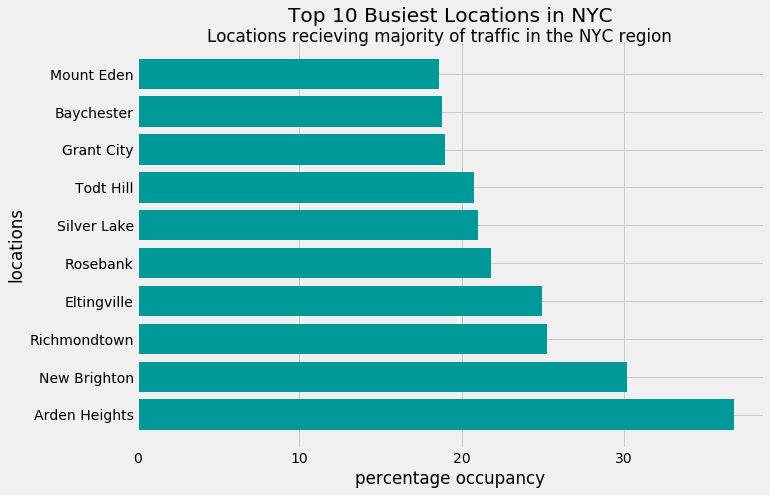

In [32]:
plt.figure(figsize=(10,7))
plt.style.use('fivethirtyeight')
plt.barh(y=Top_10.neighbourhood,width=Top_10.occupancy_percentage,color='#009999')
plt.title('Top 10 Busiest Locations in NYC',y=1.03)
plt.suptitle('Locations recieving majority of traffic in the NYC region',y=0.905)
plt.xlabel('percentage occupancy')
plt.xticks([0,10,20,30])
plt.ylabel('locations')

The graph above shows the Top 10 locations with occupancy percentages as show.

An important thing to note here is that, the `occupancy percentage` in the bar plots above arent relative to eachother. They are average percentages of all occupancy percentages for that label. In short for each label occupancy percentages is the summary statistic - mean.

For the final question we have to answer - Are there any relationships between prices and number of reviews for a given listing?<br>
Before we go ahead, the `price` column gives the price for a listing for the `minimum_nights` i.e. the price mentioned is for the minimum nights the customer has to book the listing for. Hence to even out the scale for the `price` column, we will divide the price by minimum nights required to stay, to derive `price_per_day`

In [33]:
df['price_per_day'] = df.price / df.minimum_nights

Both the concerned columns `price_per_day` and `number_of_reviews` are measured on an `interval/ratio` scale. So to understand the distribution of these variables, we plot a histogram.

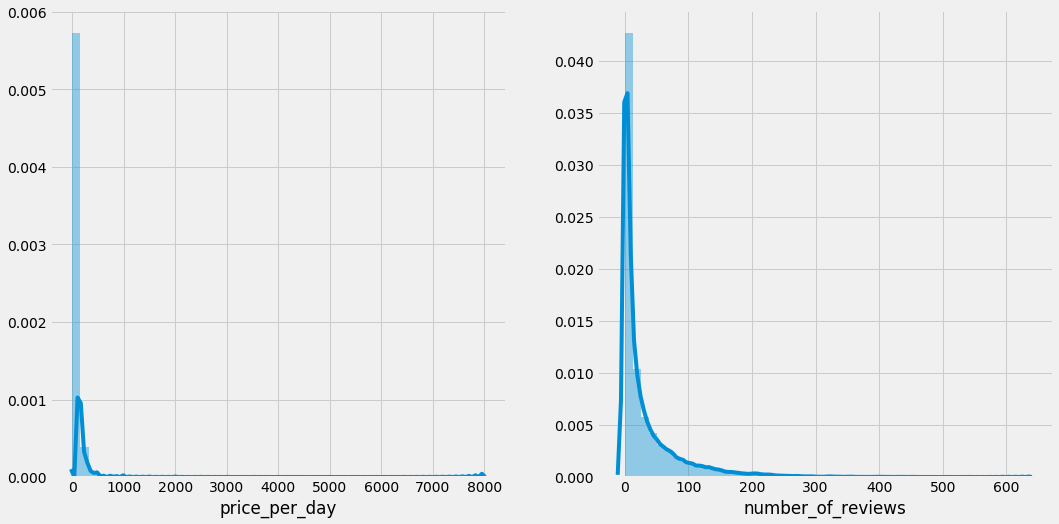

In [38]:
plt.subplots(figsize=(16,8))
plt.subplot(1,2,1)
sns.distplot(df.price_per_day,kde=True)
plt.subplot(1,2,2)
sns.distplot(df.number_of_reviews,kde=True)

Both the plots are heavily right skewed, and the distribution plot (histogram) gives us no information.

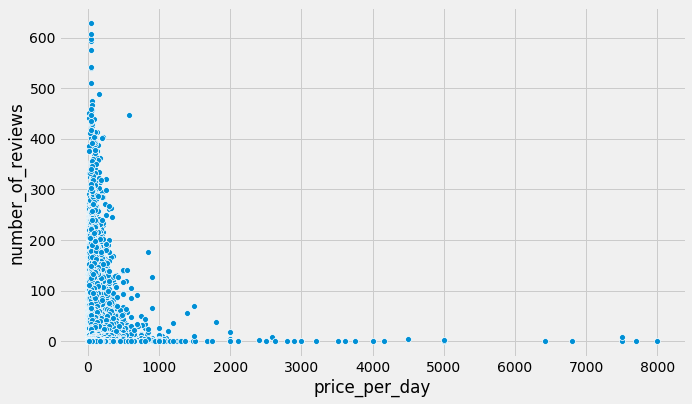

In [39]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df.price_per_day,y=df.number_of_reviews)

The two plots above, `Histograms` and the `scatter plot`, hardly give us any information pertaining to our question.<br>
Thus we might have to make some changes in one of the variables and convert it to the `ordinal scale` and hence make it comparable with respect to the other variable. Looking into the price variable.

In [291]:
df.price_per_day.describe()

count    30149.000000
mean        73.055984
std        169.476160
min          0.000000
25%         20.000000
50%         45.000000
75%         85.000000
max       8000.000000
Name: price_per_day, dtype: float64

The `price_per_day` variable has a relatively smaller mean as comapared to the extent the value go up to. Let us plot the distribution for the `price_per_day` variable where the price is below 500 dollars.

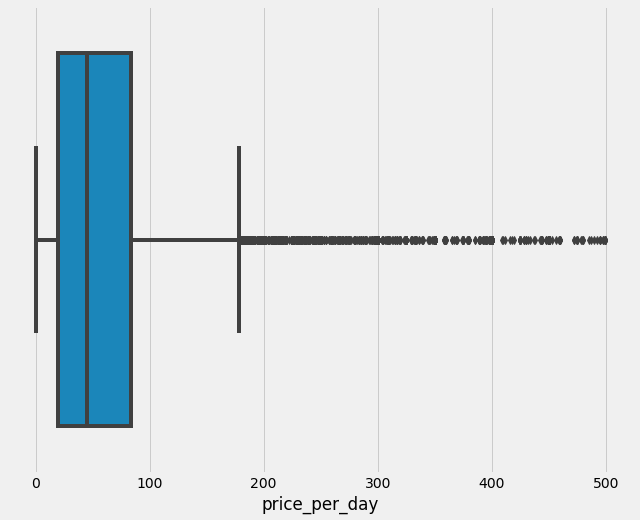

In [40]:
plt.figure(figsize=(10,8))
sns.boxplot(df[df.price_per_day < 500].price_per_day)

We can conclude that majority of listings are at a lower price point lesser than 200 dollars. Thus the intervals we segment the `price_per_day` variable in will not be equal.

We will segment `price_per_day` variable into 5 segments :-

    1. Very cheap - 15 dollars or lesser
    2. Cheap - 20 to 65 dollars
    3. Budget - 65 to 120 dollars
    4. Expensive - 120 to 200 dollars
    5. Very Expensive - 200 dollars or greater
    
Before we do that, we will remove those listings that show a per day price point of 0 dollars and per day price points greater than 1000 dollars, as these values are very high and will skew our findings. Since our purpose is to find a trend/relationship between price points of listings and the number of reviews the listing recieves, it would be okay for us to make the above assumption.

In [41]:
df = df[~((df.price_per_day == 0) | (df.price_per_day > 1000))]

In [42]:
def label(data):
    if data <= 25:
        return 'Very cheap'
    elif data > 25 and data <= 65:
        return 'Cheap'
    elif data > 65 and data <= 120:
        return 'Budget'
    elif data > 120 and data <= 200:
        return 'Expensive'
    else:
        return 'Very expensive'

df['price_per_day_labels'] = df.price_per_day.apply(label)
df.price_per_day_labels.value_counts(dropna=False).iloc[[1,0,2,3,4]]

Very cheap         9348
Cheap             10350
Budget             6235
Expensive          2709
Very expensive     1435
Name: price_per_day_labels, dtype: int64

Let us know group the data by `price_per_day_labels` column and use the aggregate function `sum` on the `number_of_reviews` column.

In [43]:
grouped = df[['price_per_day_labels','number_of_reviews']].groupby('price_per_day_labels')
df_price_range = grouped.sum().reset_index()
df_price_range

,price_per_day_labels,number_of_reviews
0,Budget,256969
1,Cheap,427814
2,Expensive,92211
3,Very cheap,152961
4,Very expensive,32915


We see there are clear differences between the price points in terms of number of reviews obtained. Let us visualize these differences so they are more understandable.

In [44]:
total_reviews = sum(df_price_range.number_of_reviews)
df_price_range['percentage'] = df_price_range.number_of_reviews / total_reviews * 100
df_price_range = df_price_range.iloc[[3,1,0,2,4]]
df_price_range

,price_per_day_labels,number_of_reviews,percentage
3,Very cheap,152961,15.885945
1,Cheap,427814,44.431128
0,Budget,256969,26.687819
2,Expensive,92211,9.576682
4,Very expensive,32915,3.418426


([<matplotlib.axis.YTick at 0x7efe3c66f550>,
 <a list of 3 Text yticklabel objects>)

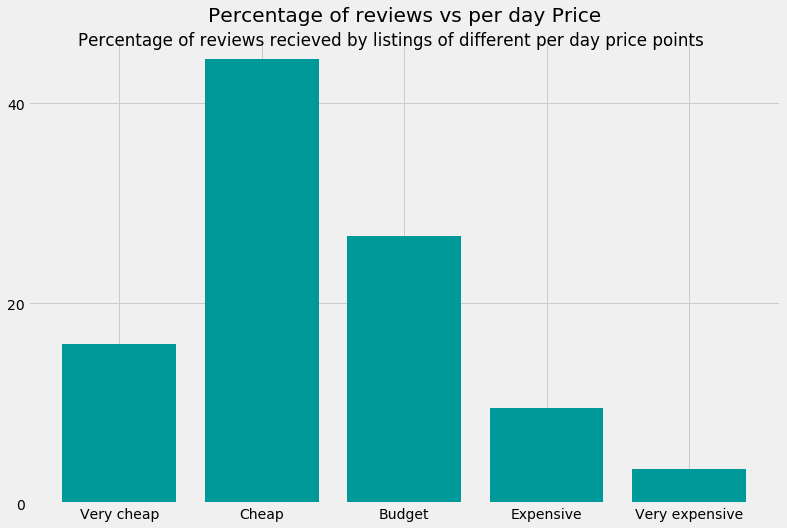

In [45]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')
plt.bar(x=df_price_range.price_per_day_labels, height=df_price_range.percentage,color='#009999')
plt.title('Percentage of reviews vs per day Price',y=1.02)
plt.suptitle('Percentage of reviews recieved by listings of different per day price points',y=0.89)
plt.yticks([0,20,40])

From the plot above we can conclude that listings that quote a per-day-price point between 20 to 120 dollars get maximum number of reviews.

In conclusion, we observed that:- 

    1. We have found the Top 50 hosts, that have high occupancy percentages(busiest)
    The properties of these Top 50 hosts are mainly situated in - Manhattan and Brooklyn.
    
    2. The Top location groups that recieve the maximum traffic are Manhattan and Brooklyn,
    As we concluded from the Top 50 busiest hosts. Accessing more granular information we 
    found the Top 10 busiest neighbourhoods.
    
    3. Listings priced closer to 20 dollars to 120 dollars on per day basis, recieve more number 
    of reviews than other price points.

